## Intro

The goal is to build a model that predicts the tag for a given question. The dataset consists of questions, such as "How do I sort a dictionary by value?", and exactly one tag (i.e. `Python`, `CSharp`, `JavaScript`, or `Java`).  

This is an example of multi-class classification.

#### Setup

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import numpy as np
import matplotlib.pyplot as plt

import collections
import pathlib
import os

import IPython.display

In [ ]:
def print_vocab(vocab, stop=None):
    print(f"Vocabulary: ", end="")
    for idx, token in enumerate(vocab):
        print(f"'{token}' ({idx})", end=", ")
        if idx == stop:
            break

def show_model_performance(history):
    for name in history:
        print(f"{name}: {history[name][-1]:.2f}")

The Stack Overflow dataset has already been divided into training and test sets, but it lacks a validation set.

### Load data

In [ ]:
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset_dir = tf.keras.utils.get_file(
    origin = data_url,
    fname = 'stack_overflow_16k.tar.gz',
    cache_dir = '/content/',
    cache_subdir = '',
    extract = True
)

os.listdir("/content/stack_overflow_16k_extracted")

['README.md', 'train', 'test']

In [ ]:
dataset_dir = "/content/stack_overflow_16k_extracted/"
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

train_python_dir = train_dir + "/python/"
files = os.listdir(train_python_dir)

filepath = train_python_dir + files[0]
with open(filepath, 'r') as f:
    print(f.read())

"on boot i have black screen with text `ubuntu 18.04.2 lts localhost tty1` ubuntu 18.04.2 lts localhost tty1 localhost login: yuliia. password: .etc/update-notd.d/80-esm: 3: etc/update notd.d/80-esm: isb release: not found .etc/update-notd.d/80-esm: 4: etc/update notd.d/ 80-esm: isb release: not found .etc/update-notd.d/ 91-release-upgrade: 4: etc/update notd.d/91- release-upgrade: isb release: not found. welcone to ubuntu 18.04.2 lts cgnlinux 4.15.0 43 generic x86 64)...i tried update blank, but removed it then again installed. after reboot i see black screen. help me please!"



### Split Data

In [ ]:
batch_size = 32
seed = 42

raw_train_ds, raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'both',
    seed = seed
)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size = batch_size
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


### Explore data

Let's take a look at a batch to get a feel for the data.

In [ ]:
for x_batch, y_batch in raw_train_ds.take(1):
    for i in range(len(x_batch)):
        q = str(np.char.decode(x_batch[i].numpy())).rstrip()
        print(f"Question: {q[:20]} ... {q[-20:]},  Label: {y_batch.numpy()[i]}")

Question: "how can i execute a ...  eval if necessary.",  Label: 2
Question: convert sql binary d ...  to string in blank?,  Label: 0
Question: "how to copy values  ...  original property?",  Label: 0
Question: "blank: programatica ... od to achieve this?",  Label: 3
Question: "smtp client , shoul ... ess is real or not.",  Label: 0
Question: "how to reset a div  ... click', function(){",  Label: 2
Question: "how to iterate step ... &gt;6):.    //logic",  Label: 3
Question: "migrating from blan ...  think are obvious.",  Label: 3
Question: "how do i change the ...        }..        }",  Label: 2
Question: "why do both blank o ... ength+ """");..}..}",  Label: 1
Question: "return an index of  ... ow would i do this?",  Label: 3
Question: "why does my string. ... gs! why is this so?",  Label: 3
Question: "how to calculate si ... h so plz forgive me",  Label: 0
Question: "hangman in blank fx ... s me from doing so.",  Label: 1
Question: "cannot access value ... ontact[key].length)",  Labe

In [ ]:
num_classes = len(raw_train_ds.class_names)
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


### Configure the datasets for performance
When loading data to make sure that I/O does not become blocking, the following methods come handy:

- **cache** keeps data in memory after it's loaded off-disk. This will ensure the dataset does not become a bottleneck while training your model.

- **prefetch** overlaps data preprocessing and model execution while training.



In [ ]:
raw_train_ds = raw_train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
raw_test_ds = raw_test_ds.prefetch(buffer_size = tf.data.AUTOTUNE)

### Prep Data

Typical preprocessing of natural lanaguage inputs are:

- **Standardization** simplifies text, by removing clutter or anything the that won't help the model (punctuation, tags, lowercase text, ...).

- **Splitting and recombining** each example is split into substrings, such as words, or n-grams.

- **Tokenization** splits strings into tokens (i.e. splitting a sentence into words using whitespaces as separators) and recombining into n-grams.

- **Vectorization** assign a unique index to tokens, and transform each example into a vector of tokens, either of ints or dense floats, so they can be fed into a neural network.

For this we have keras' `TextVectorization` layer, which maps text features to integer sequences.

The vocabulary for the layer must be either supplied on construction or learned via `adapt()`. When the layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a vocabulary from them (with unlimited or capped size).

In [ ]:
VOCAB_SIZE = 10000

# returns a vector denoting which tokens exist at least once in the input.
multi_hot_vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens = VOCAB_SIZE, # should be specified only when adapting a vocabulary.
    standardize = "lower_and_strip_punctuation",
    split = "whitespace",
    # creates an int vector per batch containing
    output_mode = "multi_hot",
)

Let's see what it does with a toy example. Here the output of the layer are multi-hot vectors with the same length as the vocabulary (a vector of tokens), with 1s where an input token map in the vocabulary. Unknown input tokens will map to the special token `[UNK]`, always present in every vocabulary.

In [ ]:
# Adapt layer to generate the vocabulary from a given corpus
corpus = ["foo bar.", "bar? baz", "<p>baz bada boom</p>", "\nque pum bar (que pam)"]
multi_hot_vectorize_layer.adapt(corpus)

# Get the vocabulary
vocab = multi_hot_vectorize_layer.get_vocabulary()
print_vocab(vocab)

input_data = [["bar foo? bar qux bar"], ["qux baz"], ["bob pam."]]
multi_hot_vectorize_layer(input_data)

Vocabulary: '[UNK]' (0), 'bar' (1), 'que' (2), 'pum' (3), 'pbaz' (4), 'pam' (5), 'foo' (6), 'boomp' (7), 'baz' (8), 'bada' (9), 

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0]])>

In [ ]:
MAX_SEQUENCE_LENGTH = 250

# replaces each token by an integer, thus preserving their order.
int_vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens = VOCAB_SIZE,
    # Outputs integer indices, one integer index per split string token.
    output_mode = 'int',
    # the output will have its time dimension padded or truncated to this length
    output_sequence_length = MAX_SEQUENCE_LENGTH,
)

In [ ]:
int_vectorize_layer.adapt(["foo bar.", "bar? baz", "<p>baz bada boom</p>", "\nque pum (que pam)"])

# Get the vocabulary
vocab = int_vectorize_layer.get_vocabulary()
print_vocab(vocab)

input_data = [["bob pam. bada, bar foo que pam (baz) foo"]]
int_vectorize_layer(input_data)

Vocabulary: '' (0), '[UNK]' (1), 'que' (2), 'bar' (3), 'pum' (4), 'pbaz' (5), 'pam' (6), 'foo' (7), 'boomp' (8), 'baz' (9), 'bada' (10), 

<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 1,  6, 10,  3,  7,  2,  6,  9,  7,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 

### Adapt Vectorization Layers

In [ ]:
# Make a text-only dataset (without labels).
train_text = raw_train_ds.map(lambda text, labels: text)

multi_hot_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

In [ ]:
vocab = multi_hot_vectorize_layer.get_vocabulary()
print_vocab(vocab, 10)

Vocabulary: '[UNK]' (0), 'the' (1), 'i' (2), 'to' (3), 'a' (4), 'is' (5), 'in' (6), 'and' (7), 'of' (8), 'if' (9), 'it' (10), 

In [ ]:
for x_example, y_example in raw_test_ds.take(1):
    print(x_example[0])

tf.Tensor(b'"beginner with parallel arrays in blank i\'ve been stuck with program for almost a week. what i\'m trying to do create a program that inputs the names of salespersons and their total sales for the month in two parallel arrays (names and sales) and determine which salesperson has the greatest sales(max)..names = ["" ""]*3.sales = [0]*3.index = 0.max = 0..k = 0..names[k] = input(""enter salesperson\'s name and monthly sales: (to exit enter   * or 0)"").sales[k] = int(input(""enter monthly sales:""))..while (names[k] !=""*""):.    if sales[k] &gt; max :.       index = k.       max = sales[index]..       k = k + 1...print(""max sales for the month: "",max).print(""salesperson: "",(names[index]))...it doesn\'t prompt the user 3 times for the name and salary it instead just asks once and i get this error:..enter salesperson\'s name and monthly sales: (to exit enter * or 0)jon enter monthly sales:3 .traceback (most recent call last): .file ""c:usersuserdownloadssales.py"", line 18

Let's check a real stack overflow question example. We extract an example from a batch, and we vectorize it using multi-hot encoding.

We'll notice the vector is highly concentrated at the beginning.

Example vector (first 30 elements of 10000): [1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 1 0]
Num of tokens: 121


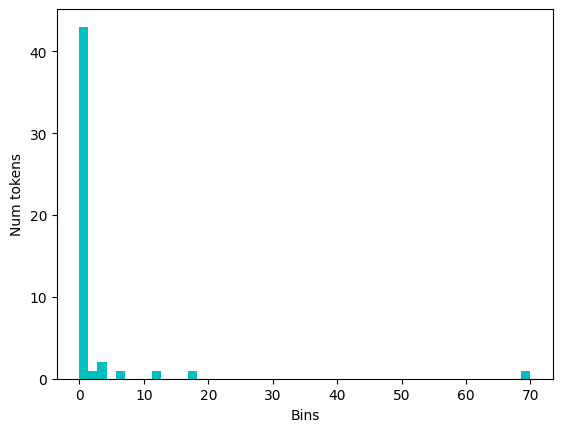

In [ ]:
x_example, y_example = raw_test_ds.take(1).get_single_element()

example_vector = multi_hot_vectorize_layer(x_example[0])

print(f"Example vector (first 30 elements of {len(example_vector)}): {example_vector.numpy()[:30]}")
print(f"Num of tokens: {np.sum(example_vector)}")

bins = [np.sum(example_vector[i:i+stride].numpy()) for i in range(0, len(example_vector), 200)]

plt.hist(bins, bins=len(bins), color='c')
plt.xlabel('Bins')
plt.ylabel('Num tokens')
plt.show()

Let's now get the int encoding.

In [ ]:
example_vector = int_vectorize_layer(x_example[0])
print(f"'int' vectorized question: {example_vector}")

'int' vectorized question: [  16   63   31    1   63   52  401  158   37    5    1  279    8  195
  215  158   21    1    1  363    4  124  694  593   12    2  126  207
  249  916    4 1519    1    7    2  212  799    9  229  363  195 1789
    4  117   94  356    2  363    7   16    1  138  100    5  114   14
    3  166  810  407   94   44  356    2   29 2205   52  158   21    1
    1    8   13  236  207    9  122    1    3   78    4   70  432  207
  389    4 1530  207   31   16  363   36  481   36  588   83 1354  389
   32  137    1  314 1047   48 2559   99   18  589   18    1 3960    1
   53   18    1    1   27    1   53 3960    1    1  126    1    1   10
   51    1   51   27  126   99    1    1    1    1    1    1    1  173
  195  150  146  520    7   16   26   11  178  882   14   58   35  368
    2  314  350  389  223    2    1  931    1  196   22   29   99   22
   18  589   41  107   22   18    1   41  107   22   63    1   41  107
   53   18    1   28  673   27    1  673   99    1

Let's check the ID-token pai of the example. Notice that `[UNK]` is often used as a placeholder to obfuscate the target label used in a question.

In [ ]:
vocab = int_vectorize_layer.get_vocabulary()
for idx in example_vector.numpy():
    if idx != 0:
        print(f"({idx}) {vocab[idx]}, ", end='')


(16) blank, (63) object, (31) from, (1) [UNK], (63) object, (52) im, (401) currently, (158) working, (37) on, (5) a, (1) [UNK], (279) project, (8) and, (195) ive, (215) been, (158) working, (21) with, (1) [UNK], (1) [UNK], (363) classes, (4) to, (124) create, (694) custom, (593) types, (12) for, (2) the, (126) output, (207) objects, (249) however, (916) due, (4) to, (1519) various, (1) [UNK], (7) in, (2) the, (212) current, (799) implementation, (9) of, (229) these, (363) classes, (195) ive, (1789) decided, (4) to, (117) try, (94) out, (356) creating, (2) the, (363) classes, (7) in, (16) blank, (1) [UNK], (138) run, (100) into, (5) a, (114) problem, (14) that, (3) i, (166) cant, (810) quite, (407) figure, (94) out, (44) when, (356) creating, (2) the, (29) class, (2205) constructors, (52) im, (158) working, (21) with, (1) [UNK], (1) [UNK], (8) and, (13) this, (236) returns, (207) objects, (9) of, (122) type, (1) [UNK], (3) i, (78) need, (4) to, (70) use, (432) those, (207) objects, (389

### Bag-of-Words Model (BoW)

The first model is a bag-of-words model (BoW). Since the multi-hot vectorized layer removes all word ordering, disregarding syntax or grammar, it is fast and may be sufficient for simple tasks as document classification, where the frequency of words may have more impact in predicting the right label, rather than the specific order of its words, which would be critical to more semantic driven tasks.




In [ ]:
EPOCHS = 10

multi_hot_model = tf.keras.Sequential([
    multi_hot_vectorize_layer,
    tf.keras.layers.Dense(4)
])

multi_hot_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

multi_hot_history = multi_hot_model.fit(
    raw_train_ds,
    validation_data = raw_val_ds,
    epochs = EPOCHS
)

IPython.display.clear_output()

show_model_performance(multi_hot_history.history)

accuracy: 0.95
loss: 0.29
val_accuracy: 0.84
val_loss: 0.49


### ConvNet Model

The model will take batched Stack Overflow questions as input and preprocess each batch into an integer matrix of size (batch, input_length). These integers of course represent the vocabulary's token ID.

The Embedding layer will ingest the preprocessed int vector, where the largest token index should be no larger than the vocabulary size, and turn the non-negative integers into a dense vector of floats.

An embedding layer is essentially a lookup table (or matrix) where the rows correspond to the vocabulary size and the columns represent the dimensionality of the dense vector we want for each word.

The token ids generated by the int vectorizer don't carry inherent meaning about the relationship between words. The embedding vectors, though, will encode words as dense vectors of floats. The neural network will hopefully capture the relationships or patterns between words found in the training data, and learn their shared similarity, for exampe of words like "cat" and "dog", both animals, and encode them 'close' together (in high-dimensional space), unlike, say, "moon".

In our case, the classification task will guide what "meaning" gets encoded. A sentiment model might encode "happy" and "joy" similarly, while a translation model might align "dog" with "perro" (Spanish).

In [ ]:
def make_model(vocab_size, num_labels, vectorizer=None):
    my_layers =[]
    if vectorizer is not None:
        # shape: (batch_size, input_length).
        my_layers = [vectorizer]

        my_layers.extend([
            # shape: (batch_size, input_length).
            tf.keras.layers.Embedding(vocab_size, 64, mask_zero=True),
            # shape: (batch_size, input_length, output_dim).
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
            tf.keras.layers.GlobalMaxPooling1D(),
            tf.keras.layers.Dense(num_labels)
        ])

    return tf.keras.Sequential(my_layers)


num_labels = 4
int_model = make_model(VOCAB_SIZE, num_labels, int_vectorize_layer)

int_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

int_history = int_model.fit(
    raw_train_ds,
    validation_data = raw_val_ds,
    epochs = EPOCHS
)

IPython.display.clear_output()

show_model_performance(int_history.history)

accuracy: 0.95
loss: 0.29
val_accuracy: 0.84
val_loss: 0.49


### Evaluate Model

In [ ]:
test_performance = {}
test_performance['MultiHot_model'] = multi_hot_model.evaluate(raw_test_ds, return_dict=True)
test_performance['Int_model'] = int_model.evaluate(raw_test_ds, return_dict=True)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7997 - loss: 0.5394
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7897 - loss: 0.6726


Text(0, 0.5, 'CE/token')

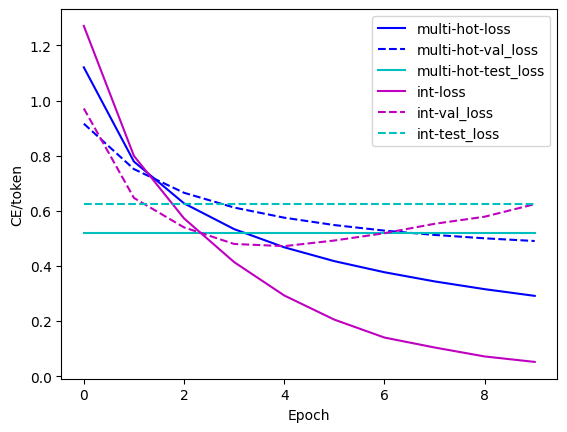

In [ ]:
plt.plot(multi_hot_history.epoch, multi_hot_history.history['loss'], label='multi-hot-loss', color='b')
plt.plot(multi_hot_history.epoch, multi_hot_history.history['val_loss'], '--', color='b', label='multi-hot-val_loss')
plt.plot(int_history.epoch, [test_performance['MultiHot_model']['loss']]*EPOCHS, color='c', label='multi-hot-test_loss')

loss = plt.plot(int_history.epoch, int_history.history['loss'], label='int-loss', color='m')
plt.plot(int_history.epoch, int_history.history['val_loss'], '--', color='m', label='int-val_loss')
plt.plot(int_history.epoch, [test_performance['Int_model']['loss']]*EPOCHS, '--', color='c', label='int-test_loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('CE/token')